In [16]:
import sys
import os
sys.path.append("/home/feity/HCgit/utils")
import draw
import matplotlib.pyplot as plt
import scanpy as sc
import scanpy.external as sce
import numpy as np
import pandas as pd
import anndata

In [2]:
mouse = {} 
mouse2 = {} 
marmoset = {} 
macaque = {} 
macaque2 = {} 
for i in os.listdir("/home/share/ST_mouse/HIP_1014/HIP_mouse/final/cell/mouse1"):
    mouse[i[:4]] = sc.read_h5ad("/home/share/ST_mouse/HIP_1014/HIP_mouse/final/cell/mouse1/"+i)
for i in os.listdir("/home/share/ST_mouse/HIP_1014/HIP_mouse/final/cell/mouse2"):
    mouse2[i[:4]] = sc.read_h5ad("/home/share/ST_mouse/HIP_1014/HIP_mouse/final/cell/mouse2/"+i)
for i in os.listdir("/home/share/ST_marmoset/HIP_1026/HIP_marmoset/final/cell/marmoset1/"):
    marmoset[i[:4]] = sc.read_h5ad("/home/share/ST_marmoset/HIP_1026/HIP_marmoset/final/cell/marmoset1/"+i)
for i in os.listdir("/home/share/ST_macaque/HIP_1015/HIP_macaque/final/cell/macaque1/"):
    macaque[i[:3]] = sc.read_h5ad("/home/share/ST_macaque/HIP_1015/HIP_macaque/final/cell/macaque1/"+i)
for i in os.listdir("/home/share/ST_macaque/HIP_1015/HIP_macaque/final/cell/macaque3/"):
    macaque2[i[:4]] = sc.read_h5ad("/home/share/ST_macaque/HIP_1015/HIP_macaque/final/cell/macaque3/"+i)


In [3]:
def capitalizeGene(adata):
    idx = [a.upper() for a in adata.var_names]
    adata.var_names = idx 
    return adata

marmosetadata = anndata.concat(marmoset, label="slice")
macaqueadata = anndata.concat(macaque, label="slice")
macaqueadata2 = anndata.concat(macaque2, label="slice")

mouseadata = anndata.concat(mouse, label="slice")
mouseadata = capitalizeGene(mouseadata)
mouseadata2 = anndata.concat(mouse2, label="slice")
mouseadata2 = capitalizeGene(mouseadata2)

/home/feity/.conda/envs/tf/lib/python3.7/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [4]:
ca1 = ["Glu CA1-1", "Glu CA1-2", "Glu CA1-3", "Glu CA1-4"]
marmosetadata = marmosetadata[marmosetadata.obs["cellType"].isin(ca1)]
mouseadata = mouseadata[mouseadata.obs["cellType"].isin(ca1)]
macaqueadata = macaqueadata[macaqueadata.obs["cellType"].isin(ca1)]

mouseadata2 = mouseadata2[mouseadata2.obs["cellType"].isin(ca1)]
macaqueadata2 = macaqueadata2[macaqueadata2.obs["cellType"].isin(ca1)]

In [5]:
adata = anndata.concat({"mouse":mouseadata, "marmoset":marmosetadata, "macaque":macaqueadata, "mouse2":mouseadata2, "macaque2":macaqueadata2}, label="species")
print(adata.shape)
sc.pp.filter_cells(adata, min_counts=400)
sc.pp.filter_genes(adata, min_cells=50)
adata.shape

(96980, 9754)


(82229, 9753)

In [6]:
sc.experimental.pp.highly_variable_genes(
        adata, flavor="pearson_residuals", n_top_genes=3000)
sc.experimental.pp.normalize_pearson_residuals(adata)

In [7]:
# sc.experimental.pp.normalize_pearson_residuals(adata)
sc.pp.pca(adata)
sce.pp.harmony_integrate(adata, "species", nclust = 20, theta=6)
sc.pp.neighbors(adata, use_rep="X_pca_harmony", n_neighbors=15, n_pcs=30)
sc.tl.umap(adata)

2024-04-24 13:53:24,477 - harmonypy - INFO - Iteration 1 of 10
2024-04-24 13:53:28,938 - harmonypy - INFO - Iteration 2 of 10
2024-04-24 13:53:33,389 - harmonypy - INFO - Converged after 2 iterations


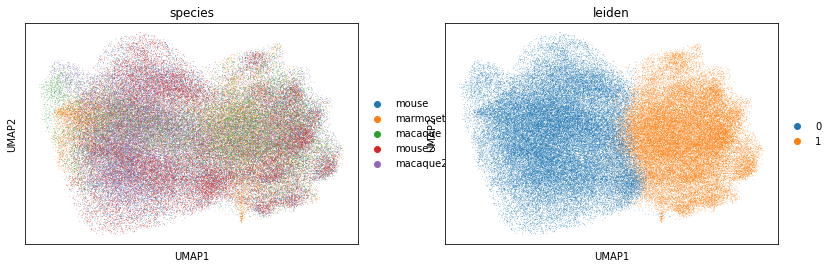

In [19]:
# sc.pp.neighbors(adata, use_rep="X_pca_harmony", n_neighbors=15, n_pcs=30)
sc.tl.leiden(adata, resolution=0.2)
# sc.tl.umap(adata)
sc.pl.umap(adata, color=["species", "leiden"])

In [11]:
seq = ["T59", "T57", "T53", "T49", "T47", "T43", "T41", "T39", "T37", "T33", "T31", "T27", "T25", 
"T30", "T32", "T34", "T36", "T40", "T42", "T44", "T48", "T50"]

df = pd.read_excel("/home/feity/HCgit/TableS1.xlsx", sheet_name="macaque")
df["EBZ"] = df["EBZ (mm)"].astype(float)
dfEBZ = df.set_index("chipID")

In [12]:
x = [] 
y = [] 
for i in seq:
    x.append(dfEBZ["EBZ"][i])
    sub = adata[adata.obs["slice"] == i]
    y.append(sub.obs["leiden"].astype(int).sum()/len(sub))

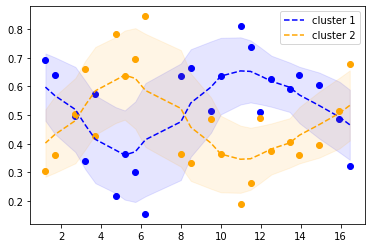

In [18]:
axis = plt.gca()
x, y = np.array(x), np.array(y)

draw.drawCellProportion(x, y, axis, label="cluster 1", c="blue")
draw.drawCellProportion(x, 1-y, axis, label="cluster 2", c="orange")
plt.legend()